# Conversation Balance

In [1]:
%%capture

import convokit
print("done importing convokit")
from convokit import Corpus

In [2]:
### Importing the Balance Transformer from convokit
from convokit.balance import Balance

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from collections import Counter
import re
from collections import Counter
from convokit import FightingWords
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.metrics import cohen_kappa_score

import random
random.seed(42)

In [4]:
corpus = Corpus(filename="/Users/seanzhangkx/Desktop/Research/CANDOR_Corpus/CANDOR-corpus-audiophile")
invalid_convo = ['80d9e496-db7f-49e3-8789-06850e62ffa1','82af78ef-4d4f-4bd3-8d20-7daa70adff61','87e8b3ce-14da-43e6-bd8b-7c3c67030559','8d0c52af-1e6d-46ca-a709-28c7ba9734ce','3045ec04-252c-420e-8646-c6b0e150ca74','fe2ec1ed-027e-404d-94c7-8fc1587aa3bc','983a1ff0-e14f-408a-a807-2e1b1cbb2a00','f5de68ee-6513-406a-b0fc-49f20873faef','ceaafa07-24d8-4398-9b1a-b825938f23e0','446fe8dc-1619-4c44-a4bd-8cbb48a2bca1','29f8f496-079b-4a71-84ff-7100bbc28824','68a27e9e-2c9d-49ac-ba58-9751d402a84b','22579311-0848-472a-a1b7-9b663fbb4aab','ee19d0ea-462c-47ef-888d-ac3254113e37','601dd44f-db11-48d6-b150-d8959e05c97f','65ec7b23-af77-449e-9b11-e431f8a3b874','0a84a137-b947-441c-b94c-a03f4a5851ea','588c5b4b-5e92-426c-8acc-686628a7342f','6ce9f678-15c4-424c-bf3f-b4e2f47a8818','c0c54a77-1d33-41a4-8e13-92a4840e82b8','13f6956b-ff2a-4ad3-aed6-8fd3cfdb2cd4','ea29afa5-e18a-47a9-93bf-87bfbb94c1d5','53459a58-b890-4cad-83dc-1fb55dbd880e','92c66875-8a3c-44f6-9356-8537655417db','b91c719a-4d41-4e24-837e-5c6abfacc77a','115ba192-7e26-497b-85b2-adf378b33387','3049cb21-cec9-46b6-ace5-8b97f4fd6165','2a4d7a05-b514-4927-a797-3644b4046f43','da272ccd-9b89-4ae4-81d4-38ed452f36d1','6fdd1fc5-e185-45e4-810d-bd8fb8b82490','1e3c22d6-422c-4921-8892-e31e09f9a2f6','60454fcf-eceb-4faf-9347-8d796e1b5be8','d9266679-7d71-43d0-ab1a-3293b589569e','49694675-cacf-452d-a940-3c93987126ef','17dbcae3-0087-49c6-af7c-c92099e3377a','a806bdc5-250b-41e7-a8c7-9440c270f3fe','0278950b-a7e0-4e15-8a2b-1629ff1b17ba','ce044258-3886-4f26-a670-d32aeeec6df9','eb326986-325e-4f6b-b895-82a1f577c797','141ea746-d1f1-402d-9b0a-a4cdb0b1c4f0','32adb5d5-910d-4547-972a-f5d0b795c689','542a6af4-84f3-4681-80ce-fce29162efc1','fe4a5de5-3b9c-4b6f-8e70-403db8a1caec','bf57c9e7-7be9-4961-a7fb-59777c0dc751','5f3c5c14-1280-48c4-b6a5-97437ea68c94','b877a5bf-3384-4ea0-bf82-cef399a1b00d','a8855c03-359f-42d9-af04-e459f9547107','98666aa9-2a23-4a64-9379-48541d73d901','765f6cde-5291-4047-89c1-d71b1e3a413d','c4caca36-1ace-44de-844a-0933eface36a','debcfb81-d883-4fb5-8c4c-cc98468c96db','030c76ab-9e19-4b78-9a7a-86cd7ba8472a','20bc98a3-efaa-4657-8448-f731bdec47cb','ec4460de-5136-4a67-90f1-a8cde16266c0','d713d070-fe2c-4327-8952-e78f45d251a8','65b9bc57-6206-475d-91ec-c5696259c0d4']
corpus = corpus.filter_conversations_by(lambda convo: convo.id not in invalid_convo)

### Pre-req: Annotate Speaker Group For each Conversation

In [5]:
for convo in tqdm(corpus.iter_conversations()):
    sp_lst = convo.get_speaker_ids()
    sp_A_id, sp_B_id = convo.meta['speaker_A'], sp_lst[0] if sp_lst[0] != convo.meta['speaker_A'] else sp_lst[1]
    convo.meta['speaker_group'] = {sp_A_id : 'groupA', sp_B_id : 'groupB', 'groupA' : sp_A_id, 'groupB' : sp_B_id}
    for utt in convo.iter_utterances():
        utt.meta['group'] = convo.meta['speaker_group'][utt.speaker.id]
        utt.meta['utt_group'] = convo.meta['speaker_group'][utt.speaker.id]

1594it [00:20, 76.35it/s]


### Apply Balance Transformer

In [6]:
primary_threshold = 0.50001 # primary speaker has to speak for more than this part of time in the conversation total speaking time
window_ps_threshold = 0.6 # primary speaker of the window has to speak for more than this part of time in window's total speaking time
window_size = 2.5 # window size in minutes
sliding_size = 30  # sliding window size in sec
cur_cut = 0 # utterance with length under cur_cut will be eliminated
remove_first_last_utt = True

In [7]:
balance_transformer = Balance(primary_threshold=primary_threshold, 
                              window_ps_threshold=window_ps_threshold, 
                              window_size=window_size,
                              sliding_size=sliding_size,
                              cur_cut=cur_cut,
                              remove_first_last_utt=remove_first_last_utt)
balance_transformer.transform(corpus)

Annotating conversation balance: 1594it [01:49, 14.60it/s]


In [8]:
convo = corpus.random_conversation()
print(f"Overall Conversation Balance for convo_id {convo.id} is: ", convo.meta['balance_score'])
print(convo.meta['primary_speaker'])

Overall Conversation Balance for convo_id 48622ac9-189b-47cd-8eb4-3e6d93ba462e is:  0.5718328104013037
groupA


### Helper Functions

In [ ]:
def read_convo(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    for utt in convo.iter_utterances():
        start = round(utt.meta['start'] / 60, 2)
        print(f"{start} \033[1m{utt.speaker.meta['group']}\033[0m: {utt.text}")

def get_convo_lst_high_enjoy_percent(corpus, convo_id_lst):
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy.count(9) / len(enjoy)

def bootstrap_95(data):
    resample_times = 1000
    all_mean = []

    for _ in range(resample_times):
        sample = random.choices(data, k=len(data))
        mean = np.mean(sample)
        all_mean.append(mean)

    lower_bound = np.percentile(all_mean, 2.5)
    upper_bound = np.percentile(all_mean, 97.5)

    return (lower_bound, upper_bound)

def bootstrap_95_percentage(data):
    resample_times = 1000
    all_percentage = []

    for _ in range(resample_times):
        sample = random.choices(data, k=len(data))
        single_time = get_convo_lst_high_enjoy_percent(corpus, sample)
        all_percentage.append(single_time)

    lower_bound = np.percentile(all_percentage, 2.5)
    upper_bound = np.percentile(all_percentage, 97.5)

    return (lower_bound*100, upper_bound*100)

def percent_A_is_B(A, B):
    count1 = len([x for x in A if x in B])
    count2 = len(A)
    return round(count1/count2, 4)

def plot_convo_type_vs_metadata(data_dict, meta_name_scale):
    x = list(data_dict.keys())
    y = [np.mean(data_dict[key]) for key in x]
    y_err = [bootstrap_95(data_dict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    x_label = [f"{a} ({len(data_dict[a])})" for a in x]

    plt.errorbar(x, y, yerr=asymmetric_error, fmt='o', capsize=5, capthick=2, label='bootstrap 95% confidence')
    plt.xticks(x, x_label, rotation=45, ha='right', fontsize=10)
    plt.xlabel('Conversation Type')
    plt.ylabel(f'Average {meta_name_scale} Rating')
    plt.title(f'Average {meta_name_scale} Rating across Convo Types')
    plt.ylim(8, 18)
    plt.grid(True)

    plt.legend()
    plt.show()

def plot_element_counts(data_list, x_name, y_name, title, note="", sorted_by=None, y_up=None, y_down=None, x_up=None, x_down=None, plot_name=None):
    counts = Counter(data_list)
    if sorted_by is not None:
        sorted_items = [(element, counts[element]) for element in sorted_by if element in counts]
    else:
        sorted_items = sorted(counts.items())
    elements = [item[0] for item in sorted_items]
    occurrences = [item[1] for item in sorted_items]
    font_size = 14
    plt.figure(figsize=(8, 6))
    plt.bar(elements, occurrences)
    for i in range(len(elements)):
      plt.text(elements[i], occurrences[i]+5, str(occurrences[i]), ha='center', fontsize=font_size)

    plt.xlabel(x_name, fontsize=font_size)
    plt.ylabel(y_name, fontsize=font_size)
    plt.title(title, fontsize=font_size)
    plt.xticks(elements, fontsize=font_size - 2)
    plt.yticks(fontsize=font_size - 2)

    plt.text(0, -0.2, note, transform=plt.gca().transAxes, fontsize=font_size, ha='left', va='top')
    if y_up is not None and y_down is not None:
        plt.ylim(y_down, y_up)
    if x_up is not None and x_down is not None:
        plt.xlim(x_down, x_up)
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

In [10]:
def plot_color_blocks(data_dict, block_length=0.5, plot_name=None):
    convo_id = list(data_dict.keys())[0]
    data = data_dict[convo_id]
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot each block, the higher absolute value of "value", darker the block
    for i, value in enumerate(data):
        if value > 0: # plot blue
            ax.add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.2, color=(0, 0, 1, value)))
        elif value < 0: # plot orange
            ax.add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.2, color=(1, 0, 0, -value)))
        elif value == 0: # plot lightgrey
            ax.add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.2, color="lightgrey"))
    ax.set_xlim(0, len(data) * block_length)
    ax.set_ylim(0, 1)
    ax.set_aspect('auto')
    ax.axis('off')
    # ax.text(0, 0.22, f"{convo_id}", fontsize=12, ha='left')
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

def plot_color_blocks_multi(data_lists, block_length=0.5, plot_name=None):
    num_lists = len(data_lists)
    num_columns = 2
    num_rows = (num_lists + 1) // num_columns

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(8, num_rows*0.5))

    axs = axs.flatten()

    # Plot each list in its own subplot
    for idx, data_dict in enumerate(data_lists):
        # Plot each block, the higher absolute value of "value", darker the block
        for convo_id, data in data_dict.items():
            for i, value in enumerate(data):
                if value > 0: # plot blue
                    axs[idx].add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.5, color=(0, 0, 1, value)))
                elif value < 0: # plot red
                    axs[idx].add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.5, color=(1, 0, 0, -value)))
                elif value == 0: # plot lightgrey
                    axs[idx].add_patch(plt.Rectangle((i * block_length, 0), block_length, 0.5, color="lightgrey"))
                else:
                    print("invalid other case")
            axs[idx].set_xlim(0, len(data) * block_length)
            axs[idx].set_ylim(0, 0.1)
            axs[idx].set_aspect('auto')
            axs[idx].axis('off')
            # axs[idx].text(0, -0.02, f"{convo_id}", fontsize=7, ha='left')

    if num_lists % num_columns:
        axs[-1].axis('off')

    plt.tight_layout()
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

In [98]:
def plot_individual_conversation_floors(corpus, convo_id, plot_name=None):
    groups = balance_transformer._sliding_window(corpus, convo_id)
    convo_plot_lst = []
    score_lst = []
    convo = corpus.get_conversation(convo_id)
    ps = convo.meta['primary_speaker']
    ss = convo.meta['secondary_speaker']
    for window in groups:
        window_ps_time = window[ps]
        window_ss_time = window[ss]
        window_total_time = window_ps_time+window_ss_time
        window_id = 0
        if window_total_time == 0: # No Speaking Time in the window
            window_id = -100
            continue # skipping no speaking time windows for now
            # no_speaking_time_count += 1
        elif window_ps_time >= window_ss_time:
            window_id = window_ps_time / window_total_time if window_ps_time / window_total_time > window_ps_threshold else 0
        elif window_ps_time < window_ss_time:
            window_id = -1 * window_ss_time / window_total_time if window_ss_time / window_total_time > window_ps_threshold else 0
        convo_plot_lst.append(window_id)
        score_lst.append(round(window_id, 2))
    plot_color_blocks({convo_id: convo_plot_lst}, plot_name=plot_name)
    try:
      print(f"red : {round(convo.meta['percent_red'], 2)}, blue : {round(convo.meta['percent_blue'], 2)}, gray : {round(convo.meta['percent_gray'], 2)}")
    except:
      pass

In [100]:
def plot_multi_conversation_floors(corpus, convo_id_lst, plot_name=None):
    result_lst = []
    for convo_id in convo_id_lst:
        groups = balance_transformer._sliding_window(corpus, convo_id)
        convo = corpus.get_conversation(convo_id)
        ps = convo.meta['primary_speaker']
        ss = convo.meta['secondary_speaker']
        convo_plot_lst = []
        for window in groups:
            window_ps_time = window[ps]
            window_ss_time = window[ss]
            window_total_time = window_ps_time+window_ss_time
            window_id = 0
            if window_total_time == 0: # No Speaking Time in the window
                window_id = -100
                continue # skipping no speaking time windows for now
                # no_speaking_time_count += 1
            elif window_ps_time >= window_ss_time:
                window_id = window_ps_time / window_total_time if window_ps_time / window_total_time > window_ps_threshold else 0
            elif window_ps_time < window_ss_time:
                window_id = -1 * window_ss_time / window_total_time if window_ss_time / window_total_time > window_ps_threshold else 0
            convo_plot_lst.append(window_id)
        result_lst.append({convo_id : convo_plot_lst})
    plot_color_blocks_multi(result_lst, plot_name=plot_name)

## Visualizations

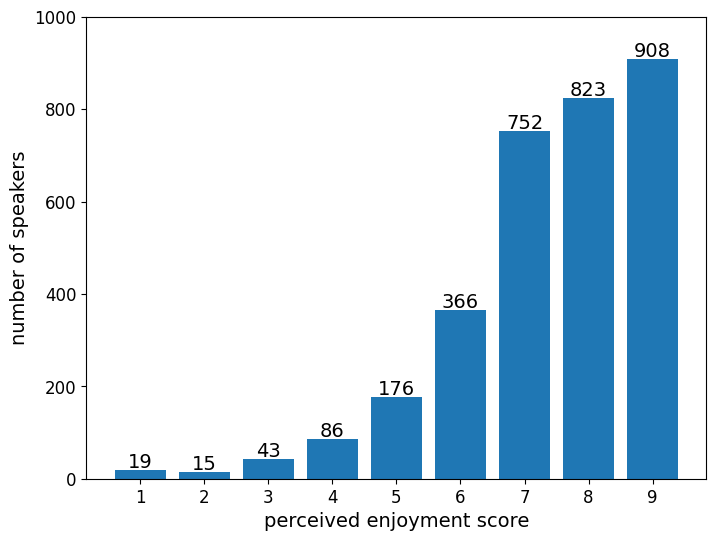

In [67]:
# Figure 1: Speaker Enjoyment Score Distribution
enjoyment_ps, enjoyment_ss = [], []
for convo in corpus.iter_conversations():
    if convo.meta['primary_speaker'] == None: continue
    enjoyment_ps.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    enjoyment_ss.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

plot_element_counts(enjoyment_ps+enjoyment_ss, "perceived enjoyment score", "number of speakers", "", y_up=1000, y_down=0)

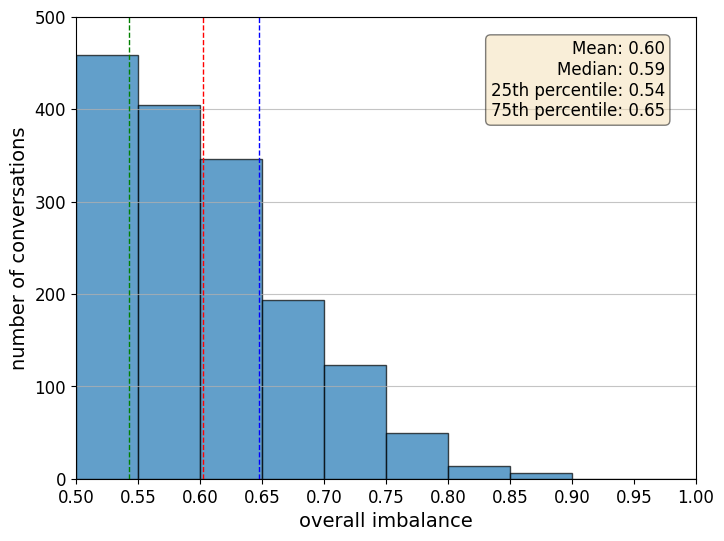

In [ ]:
# Figure 2: Overall Balance Distribution
def check_balance_distribution():
    balance_score = []
    for convo in corpus.iter_conversations():
        if convo.meta['primary_speaker'] == None: continue
        balance_score.append(convo.meta['balance_score'])

    font_size = 14

    plt.figure(figsize=(8, 6))
    plt.hist(balance_score, bins=np.arange(0, 1.1, 0.05), edgecolor='black', alpha=0.7)
    plt.xlabel('overall imbalance', fontsize=font_size)
    plt.ylabel('number of conversations', fontsize=font_size)
    # plt.title('Distribution of Balance_Score with Preprocessing')
    plt.xticks(np.arange(0, 1.1, 0.05), fontsize=font_size-2)
    plt.yticks(fontsize=font_size - 2)
    plt.grid(axis='y', alpha=0.75)
    plt.ylim(0, 500)
    plt.xlim(0.5, 1.0)

    plt.axvline(np.mean(balance_score), color='r', linestyle='--', linewidth=1, label='Mean')
    plt.axvline(np.percentile(balance_score, 25), color='g', linestyle='--', linewidth=1, label='25th percentile')
    plt.axvline(np.percentile(balance_score, 75), color='b', linestyle='--', linewidth=1, label='75th percentile')


    textstr = f'Mean: {np.mean(balance_score):.2f}\nMedian: {np.median(balance_score):.2f}\n25th percentile: {np.percentile(balance_score, 25):.2f}\n75th percentile: {np.percentile(balance_score, 75):.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=font_size-2,
            verticalalignment='top', horizontalalignment='right', bbox=props)

    # plt.savefig("plots/balance-distribution.png")
    plt.show()

check_balance_distribution()

### Categorize Based On Overall Conversation Balance

In [69]:
def get_convo_balance_type(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    if convo.meta["balance_score"] >= 0.65:
        return 'low_balance'
    elif convo.meta["balance_score"] >= 0.55:
        return 'mid_balance'
    elif convo.meta["balance_score"] >= 0.5:
        return 'high_balance'
    else:
        return 'invalid'

def annotate_conversation_balance_type(corpus):
    for convo in corpus.iter_conversations():
        convo.meta['balance_type'] = get_convo_balance_type(corpus, convo.id)

In [70]:
annotate_conversation_balance_type(corpus)

In [71]:
all_bt = [convo.meta['balance_type'] for convo in corpus.iter_conversations()]
print(f"high_balance: {all_bt.count('high_balance')}, mid_balance: {all_bt.count('mid_balance')}, low_balance: {all_bt.count('low_balance')}")

high_balance: 459, mid_balance: 750, low_balance: 385


In [ ]:
# Todo: Add stats of speaker enjoyment score for each balance group, and show that mean is different using mann whitney u test (high vs low)

In [ ]:
# Todo: Fighting words between high and low balance groups - Table 2

In [72]:
enjoyment_ps, enjoyment_ss = [], []

balance_to_enjoyment = {}

for convo in corpus.iter_conversations():
    if convo.meta['primary_speaker'] == None: continue
    enjoyment_ps.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    enjoyment_ss.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

    cur_balance = convo.meta['balance_score']
    cur_balance = round((cur_balance * 100) / 5) * 5
    if cur_balance == None: continue
    if cur_balance not in balance_to_enjoyment.keys():
        balance_to_enjoyment.update({cur_balance : {"ps" : [], "ss" : []}})
    balance_to_enjoyment[cur_balance]['ps'].append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
    balance_to_enjoyment[cur_balance]['ss'].append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

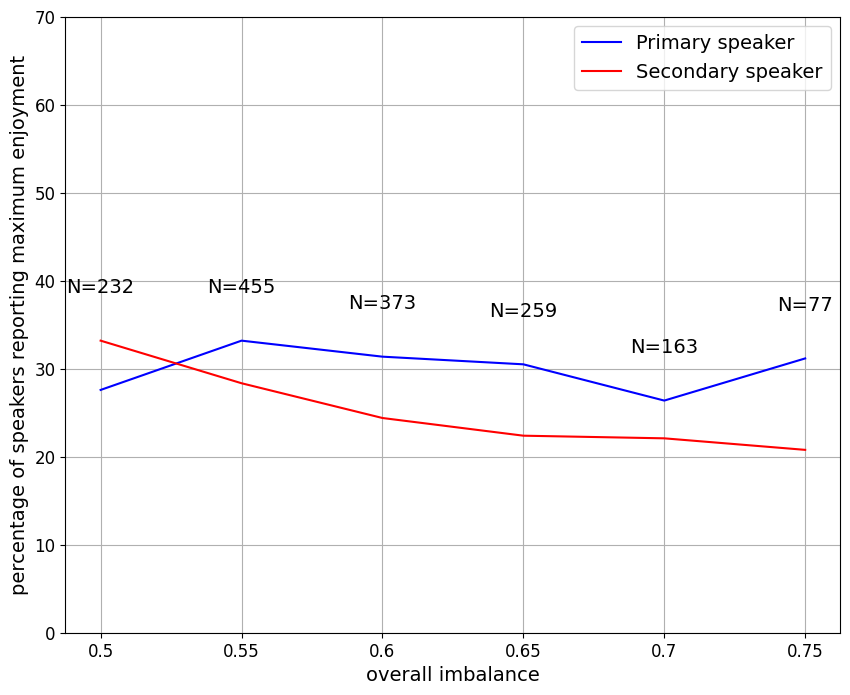

In [73]:
### Figure 3

selected = [9] # can be changed to [8, 9] or even more ratings

def plot_percentage_speaker_high_enjoy_at_various_balance_level(balance_to_enjoyment, high_enjoy_score=selected, plot_name=None):
    balance_to_enjoyment_exp = {}
    for k, v in balance_to_enjoyment.items():
        balance_to_enjoyment_exp.update({k : {'ps' : 0, 'ss' : 0}})
        for kk, vv in v.items():
            balance_to_enjoyment_exp[k][kk] = percent_A_is_B(vv, high_enjoy_score)

    x_values = [x for x in sorted(list(balance_to_enjoyment_exp.keys())) if x <  80] # below 85
    # x_values = [x for x in sorted(list(balance_to_enjoyment_exp.keys()))]
    ps_values = [balance_to_enjoyment_exp[x]['ps'] for x in x_values]
    ss_values = [balance_to_enjoyment_exp[x]['ss'] for x in x_values]
    x_length = [len(balance_to_enjoyment[x]['ps']) for x in x_values]

    my_x_labels = [str(x/100) for x in x_values]

    ps_values = [val * 100 for val in ps_values]
    ss_values = [val * 100 for val in ss_values]

    font_size = 14

    plt.figure(figsize=(10, 8))
    plt.plot(x_values, ps_values, label='Primary speaker', color='blue')  # Plot 'ps' values
    plt.plot(x_values, ss_values, label='Secondary speaker', color='red')  # Plot 'ss' values
    plt.legend(fontsize=font_size, loc ="upper right")

    for i, label in enumerate(x_length):
        y_offset = max(ps_values[i], ss_values[i]) + 5  # dynamically calculate offset
        plt.text(x_values[i], y_offset, f"N={label}", ha='center', va='bottom', fontsize=font_size)

    plt.xticks(ticks=x_values, labels=my_x_labels, fontsize=font_size - 2)
    # plt.title(f'Primary / Secondary Speaker High Enjoyment (9) percentage at each balance level')
    plt.xlabel('overall imbalance', fontsize=font_size)
    plt.ylabel('percentage of speakers reporting maximum enjoyment', fontsize=font_size)
    plt.yticks(fontsize=font_size-2)
    plt.ylim(0, 70)
    plt.legend()
    plt.grid(True)

    if plot_name is not None:
        plt.savefig(plot_name)

    # Show the plot
    plt.show()

plot_percentage_speaker_high_enjoy_at_various_balance_level(balance_to_enjoyment, high_enjoy_score=selected)

In [ ]:
# Todo: Fighting words between Primary and Secondary Speaker - Table 3

In [ ]:
# We notice primary and secondary speakers enjoy conversations differently, we do Wilcoxon T-test to check if the difference in distribution of primary / secondary speakers' enjoyment ratings is significant.
# Statistical Test Showing Enjoyment Difference between Primary and Secondary Speaker
stat, p_value = wilcoxon(enjoyment_ps, enjoyment_ss, alternative="greater")
print('Statistics=%.3f, p=%.6f' % (stat, p_value))

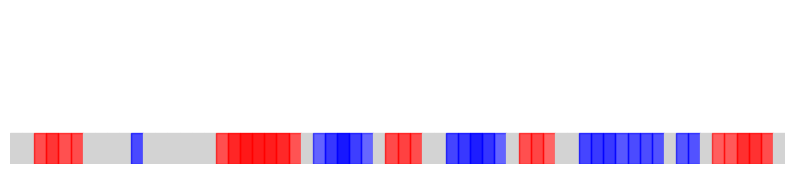

red : 31.25, blue : 34.38, gray : 34.38


In [81]:
### Figure 4 - Example plot of individual conversation balance
plot_individual_conversation_floors(corpus, "a7b14ca1-0b36-42b9-ad4a-50f0eb094035")
# convo = corpus.get_conversation("a7b14ca1-0b36-42b9-ad4a-50f0eb094035")
# print(f"red : {round(convo.meta['percent_red'], 2)}, blue : {round(convo.meta['percent_blue'], 2)}, gray : {round(convo.meta['percent_gray'], 2)}")

## Classify Conversations into Triangle Categories

In [19]:
def floor_lst_parts_percentages(lst):
    count_1 = lst.count(1)
    count_0 = lst.count(0)
    count_neg1 = lst.count(-1)
    total_elements = len(lst)

    percent_1 = (count_1 / total_elements) * 100
    percent_0 = (count_0 / total_elements) * 100
    percent_neg1 = (count_neg1 / total_elements) * 100

    return percent_1, percent_0, percent_neg1

def annotate_convo_RGB_percent(corpus):
    for convo in corpus.iter_conversations():
        percent_1, percent_0, percent_neg1 = floor_lst_parts_percentages(convo.meta['balance_lst'])
        convo.meta['percent_blue'] = percent_1
        convo.meta['percent_gray'] = percent_0
        convo.meta['percent_red'] = percent_neg1

In [20]:
annotate_convo_RGB_percent(corpus)

### Triangle 1: (Blue) Dominating Throughout

Here, we define dominating throughout type conversation as having more than 75% of windows as blue windows.

In [23]:
def get_type_dominating_throughout(balance_lst, dominating_throughout_threshold=75):
    if balance_lst == []: return "invalid"
    count_ones = balance_lst.count(1)
    percent_ones = (count_ones / len(balance_lst)) * 100
    count_neg_ones = balance_lst.count(-1)
    percent_neg_ones = (count_neg_ones / len(balance_lst)) * 100
    return percent_ones >= dominating_throughout_threshold or percent_neg_ones >= dominating_throughout_threshold

In [75]:
type_dominating_through = [convo.id for convo in corpus.iter_conversations() if get_type_dominating_throughout(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_dominating_through)}" 

'Number of Dominating Throughout Conversations: 295'

### Triangle 2: (Gray) Back and Forth

We define back and forth type conversation as having more than 60% of windows as gray windows.

In [25]:
def get_type_back_and_forth(balance_lst, back_and_forth_threshold=60):
    if balance_lst == []: return "invalid"
    count_zeros = balance_lst.count(0)
    percent_zeros = (count_zeros / len(balance_lst)) * 100
    return percent_zeros >= back_and_forth_threshold

In [76]:
type_back_and_forth = [convo.id for convo in corpus.iter_conversations() if get_type_back_and_forth(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_back_and_forth)}" 

'Number of Dominating Throughout Conversations: 251'

### Triangle 3: (Red) Alternating Dominance

We define alternating dominance as having more than 25% of windows as red windows.

In [27]:
def get_type_interleaved(balance_lst, red_threshold=25):
    if balance_lst == []: return "invalid"
    count_neg1 = balance_lst.count(-1)
    total_elements = len(balance_lst)
    percent_neg1 = (count_neg1 / total_elements) * 100
    return percent_neg1 > red_threshold

In [77]:
type_interleave = [convo.id for convo in corpus.iter_conversations() if get_type_interleaved(convo.meta['balance_lst']) and not get_type_dominating_throughout(convo.meta['balance_lst'])]
f"Number of Dominating Throughout Conversations: {len(type_interleave)}"

'Number of Dominating Throughout Conversations: 96'

In [ ]:
# Annotate Convo Triangle Types
def annotate_convo_triangle_types(corpus):
    count1, count2, count3, count4 = 0, 0, 0, 0
    three_types_dict = {'dominating_throughout' : [], 'back_and_forth' : [], 'interleaved' : [], 'no_label' : []}
    for convo in corpus.iter_conversations():
        balance_lst = convo.meta['balance_lst']
        if get_type_dominating_throughout(balance_lst):
            convo.meta['triangle_type'] = 'dominating_throughout'
            count1 += 1
            three_types_dict['dominating_throughout'].append(convo.id)
        elif get_type_back_and_forth(balance_lst):
            convo.meta['triangle_type'] = "back_and_forth"
            count2 += 1
            three_types_dict['back_and_forth'].append(convo.id)
        elif get_type_interleaved(balance_lst):
            convo.meta['triangle_type'] = 'interleaved'
            count3 += 1
            three_types_dict['interleaved'].append(convo.id)
        else:
            convo.meta['triangle_type'] = None
            count4 += 1
            three_types_dict['no_label'].append(convo.id)
    print(f"Triangle Typology: dominating_throughout: {count1}, back_and_forth: {count2}, interleaved: {count3}, no_label: {count4}")
    return three_types_dict

In [30]:
three_types_dict = annotate_convo_triangle_types(corpus)

Triangle Typology: dominating_throughout: 295, back_and_forth: 251, interleaved: 96, no_label: 952


In [31]:
def get_convo_balance_for_convo_lst(corpus, convo_id_lst):
    return np.mean([corpus.get_conversation(convo_id).meta[f'balance_score'] for convo_id in convo_id_lst])

def get_convo_avg_color_for_convo_lst(corpus, convo_id_lst, color):
    return np.mean([corpus.get_conversation(convo_id).meta[f'percent_{color}'] for convo_id in convo_id_lst])

## Enjoyment Difference across Triangle Categories

In [78]:
# Overall Balance Across Three types
for k, v in three_types_dict.items():
    print(f"mean balance for {k}: {round(get_convo_balance_for_convo_lst(corpus, v), 3)}")
print()
for k, v in three_types_dict.items():
    print(f"average color percent for {k}: Blue: {round(get_convo_avg_color_for_convo_lst(corpus, v, 'blue'), 3)}%, Red : {round(get_convo_avg_color_for_convo_lst(corpus, v, 'red'), 3)}%, Gray : {round(get_convo_avg_color_for_convo_lst(corpus, v, 'gray'), 3)}%")

mean balance for dominating_throughout: 0.719
mean balance for back_and_forth: 0.536
mean balance for interleaved: 0.527
mean balance for no_label: 0.592

average color percent for dominating_throughout: Blue: 87.455%, Red : 1.046%, Gray : 11.499%
average color percent for back_and_forth: Blue: 22.536%, Red : 6.699%, Gray : 70.765%
average color percent for interleaved: Blue: 36.138%, Red : 30.774%, Gray : 33.088%
average color percent for no_label: Blue: 50.178%, Red : 9.164%, Gray : 40.658%


In [ ]:
# Enjoyment difference between high-balance / high-imbalance conversations
def get_speaker_max_enjoy_percent_convo_lst(corpus, convo_id_lst):
    # Here max enjoyment is 9
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy, round(enjoy.count(9) / len(enjoy), 6)*100, round(np.mean(enjoy), 4)

highly_balanced = [convo.id for convo in corpus.iter_conversations() if convo.meta['balance_type'] == 'high_balance']
highly_imbalanced = [convo.id for convo in corpus.iter_conversations() if convo.meta['balance_type'] == 'low_balance']

balance_enjoy, balance_percent, balance_mean = get_speaker_max_enjoy_percent_convo_lst(corpus, highly_balanced)
imbalance_enjoy, imbalance_percent, imbalance_mean = get_speaker_max_enjoy_percent_convo_lst(corpus, highly_imbalanced)

print(f"highly_balanced:: percent: {balance_percent}%, mean: {balance_mean}, N = {len(highly_balanced)}")
print(f"highly_imbalanced: percent: {imbalance_percent}%, mean: {imbalance_mean}, N = {len(highly_imbalanced)}")

u_statistic, p_value = mannwhitneyu(balance_enjoy, imbalance_enjoy, alternative='two-sided')
print("U Statistic:", u_statistic)
print("P Value:", p_value)

highly_balanced:: percent: 31.8083%, mean: 7.5316, N = 459
highly_imbalanced: percent: 25.3247%, mean: 7.2468, N = 385
U Statistic: 391418.0
P Value: 8.992704770891266e-05


### Overall balance distribution across two balanced categories

In [39]:
interleave_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['interleaved']]
backforth_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['back_and_forth']]
dominate_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in three_types_dict['dominating_throughout']]

print("mean balance score across triangle types:")
print(f"\tinterleave: {round(np.mean(interleave_balance),3)}, backforth: {round(np.mean(backforth_balance), 3)}, dominate: {round(np.mean(dominate_balance), 2)}")

interleave_enjoy = []
for idx in three_types_dict['interleaved']:
  convo = corpus.get_conversation(idx)
  interleave_enjoy += list(convo.meta['how_enjoyable'].values())
backforth_enjoy = []
for idx in three_types_dict['back_and_forth']:
  convo = corpus.get_conversation(idx)
  backforth_enjoy += list(convo.meta['how_enjoyable'].values())
dominate_enjoy = []
for idx in three_types_dict['dominating_throughout']:
  convo = corpus.get_conversation(idx)
  dominate_enjoy += list(convo.meta['how_enjoyable'].values())

print("mean enjoyment score across triangle types:")
print(f"\tinterleave: {round(np.mean(interleave_enjoy), 2)}, backforth: {round(np.mean(backforth_enjoy), 2)}, dominate: {round(np.mean(dominate_enjoy), 1)}")

print("mann whitney u-test between back-and-forth and alternating-dominance:")
u_statistic, p_value = mannwhitneyu(interleave_enjoy, backforth_enjoy, alternative='two-sided')
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

print("mann whitney u-test between back-and-forth and dominating-throughout:")
u_statistic, p_value = mannwhitneyu(backforth_enjoy, dominate_enjoy, alternative='two-sided')
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

mean balance score across triangle types:
	interleave: 0.527, backforth: 0.536, dominate: 0.72
mean enjoyment score across triangle types:
	interleave: 7.79, backforth: 7.26, dominate: 7.2
mann whitney u-test between back-and-forth and alternating-dominance:
	U Statistic: 58215.0
	P Value: 1.2633561981776604e-05
mann whitney u-test between back-and-forth and dominating-throughout:
	U Statistic: 149013.5
	P Value: 0.8554813347177187


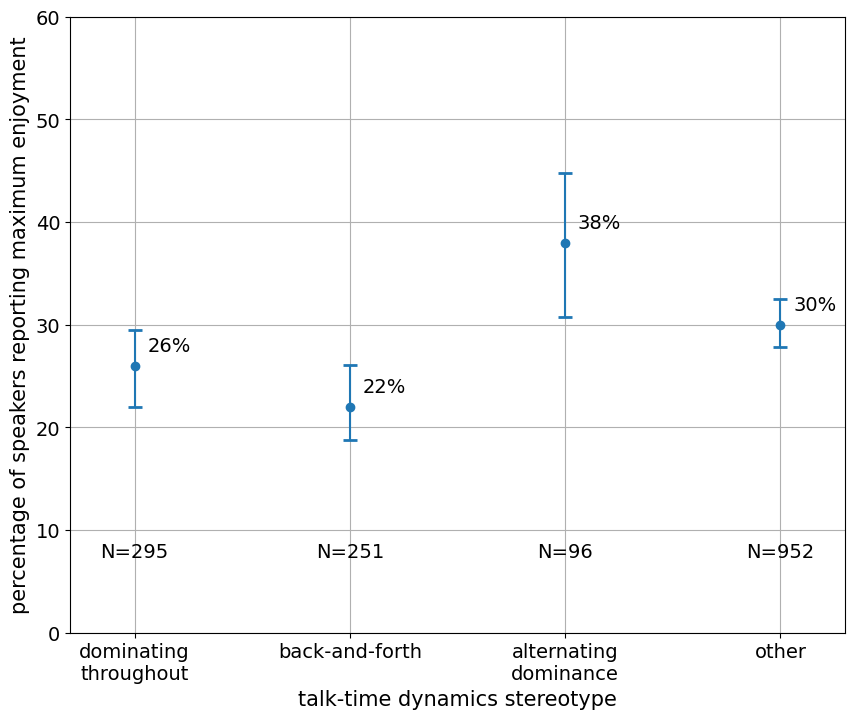

In [83]:
# Figure 5: Enjoyment Percentage at Different Conversation Types
cur_balance_type = None
meta_name = "how_enjoyable"

four_types_dict_enjoy_percent = {'dominating_throughout' : [], 'back_and_forth' : [], 'interleaved' : [], 'no_label' : []}

data = three_types_dict

for idx, v in data.items():
  four_types_dict_enjoy_percent[idx] = v

data_dict = four_types_dict_enjoy_percent

x = list(data_dict.keys())
y = [round(get_convo_lst_high_enjoy_percent(corpus, data_dict[key]), 2)*100 for key in x]
num_of_convo = [len(data_dict[key]) for key in x]
y_err = [bootstrap_95_percentage(data_dict[key]) for key in x]

lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
asymmetric_error = [lower_errors, upper_errors]

x_label = ['dominating\nthroughout', 'back-and-forth', "alternating\ndominance", "other"]

def make_plot(x_label, y, asymmetric_error, plot_name=None):
    plt.figure(figsize=(10, 8))
    plt.errorbar(x_label, y, yerr=asymmetric_error, fmt='o', capsize=5, capthick=2)
    plt.xlabel('talk-time dynamics stereotype', fontsize=15)
    plt.ylabel(f'percentage of speakers reporting maximum enjoyment', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 60)
    plt.xlim(-0.3, len(x_label)-0.7)
    for i, value in enumerate(y):
        plt.text(i+0.16, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 7, f"N={str(num_of_convo[i])}", ha='center', va='bottom')
    plt.grid(True)

    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()

make_plot(x_label, y, asymmetric_error)

In [ ]:
# C ontrolled comparison between back-and-forth and alternating dominance stereotypical conversations that are paired by their conversation-level imbalance
def find_closest_pairs(list1, list2, x=0.005):
    list1final = []
    list2final = []
    for dict1 in list1:
      idx1, score1 = next(iter(dict1.items()))
      closest_dict = None
      min_diff = float('inf')
      for dict2 in list2:
          idx2, score2 = next(iter(dict2.items()))
          diff = abs(score1 - score2)
          if diff < min_diff:
              min_diff = diff
              closest_dict = dict2
      if min_diff > x: continue
      idxf, scoref = next(iter(closest_dict.items()))
      list1final.append(idx1)
      list2final.append(idxf)
      list2.remove(closest_dict)

    return list1final, list2final

interleave_balance = [{idx : corpus.get_conversation(idx).meta['balance_score']} for idx in three_types_dict['interleaved']]
backforth_balance = [{idx : corpus.get_conversation(idx).meta['balance_score']} for idx in three_types_dict['back_and_forth']]
# print(len(interleave_balance), len(backforth_balance))
# random.shuffle(interleave_balance)
# random.shuffle(backforth_balance)
control_interleave, control_backforth = find_closest_pairs(interleave_balance, backforth_balance)
print(f"Number of pairs found: {len(control_interleave)}")
control_interleave_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_interleave]
control_backforth_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_backforth]
u_statistic, p_value = wilcoxon(control_interleave_balance, control_backforth_balance, alternative='two-sided')
print("Balance p-value:")
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)
# print(len(control_interleave), len(control_backforth))
control_interleave_enjoy = []
for idx in control_interleave:
  convo = corpus.get_conversation(idx)
  control_interleave_enjoy += list(convo.meta['how_enjoyable'].values())
control_backforth_enjoy = []
for idx in control_backforth:
  convo = corpus.get_conversation(idx)
  control_backforth_enjoy += list(convo.meta['how_enjoyable'].values())
u_statistic, p_value = wilcoxon(control_interleave_enjoy, control_backforth_enjoy, alternative='two-sided')
print("Enjoyment p-value:")
print("\tU Statistic:", u_statistic)
print("\tP Value:", p_value)

Number of pairs found: 93
Balance p-value:
	U Statistic: 1975.0
	P Value: 0.4199255535954207
Enjoyment p-value:
	U Statistic: 3837.0
	P Value: 0.020640740356370518


In [ ]:
# Todo: Fighting words between Back-and-Forth and Alternating Dominance - Table 4

### Moving Along Axis - Fix Blue, Move along Red vs Gray block

In [43]:
def get_convo_lst_enjoy_per(corpus, convo_id_lst):
    enjoy = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        enjoy += list(convo.meta['how_enjoyable'].values())
    if len(enjoy) == 0:
        return "no convo"
    return enjoy.count(9) / len(enjoy)

In [44]:
blue_below_50 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_blue'] < 50]
fix_red_level_groups = {"0_10" : [], "10_20" : [], "20_30" : [], "30_40" : [], "40_50" : []}

def get_bin_red(percent_red):
    if 0 <= percent_red < 10:
        return "0_10"
    elif 10 <= percent_red < 20:
        return "10_20"
    elif 20 <= percent_red < 30:
        return "20_30"
    elif 30 <= percent_red < 40:
        return "30_40"
    elif 40 <= percent_red < 50:
        return "40_50"
    else:
        return None

for convo_id in blue_below_50:
    # if convo_id in invalid_convo: continue
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_red(convo.meta['percent_red'])
    if bin_id in fix_red_level_groups.keys():
        fix_red_level_groups[bin_id].append(convo.id)

def get_avg_convo_percent_blue(corpus, convo_id_lst):
    percent_blues = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_blues.append(convo.meta['percent_blue'])
    if len(percent_blues) == 0:
        return "no convo"
    return round(sum(percent_blues) / len(percent_blues), 2)

In [45]:
x = list(fix_red_level_groups.keys())
y = [round(get_convo_lst_enjoy_per(corpus, fix_red_level_groups[x[i]]),4)*100 for i in range(len(x))]
y_err = [bootstrap_95_percentage(fix_red_level_groups[key]) for key in x]

lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
asymmetric_error = [lower_errors, upper_errors]

num_of_convo = [len(fix_red_level_groups[a]) for a in x]

x_names = ["0-10", "10-20", "20-30", "30-40", "40-50"]
x = [x_names[i] for i in range(len(x))]
y = [round(y[i],2) for i in range(len(x))]


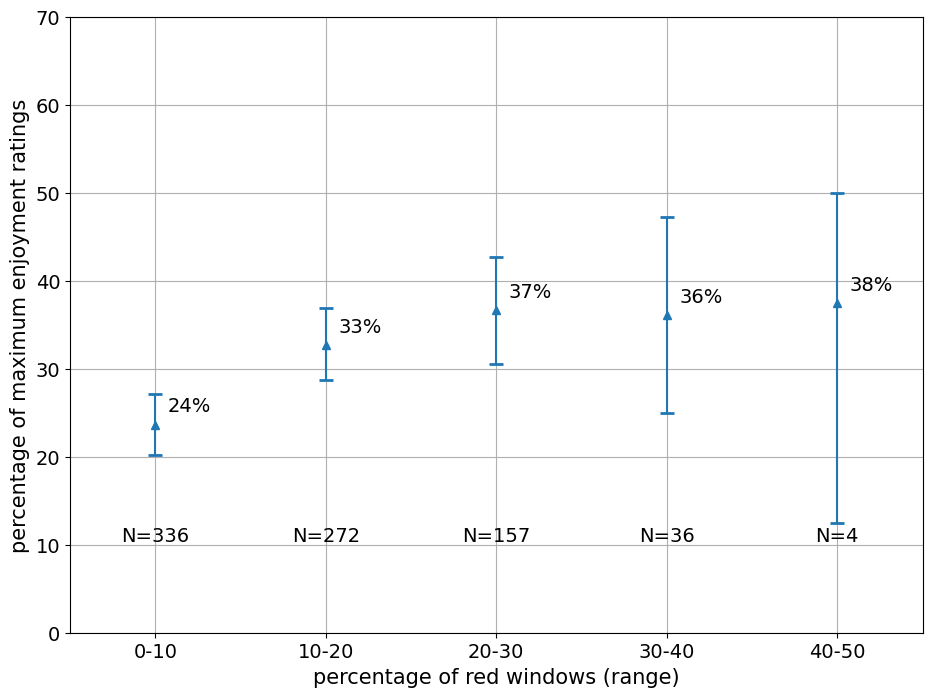

In [46]:
plt.figure(figsize=(11, 8))
plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2)
plt.xlabel('percentage of red windows (range)', fontsize=15)
plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for i, value in enumerate(y):
    plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

for i, value in enumerate(y):
    plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

plt.ylim(0, 70)
plt.xlim(-0.5, len(x_names) - 0.5)
plt.grid(True)
plt.show()

### Moving along blue-gray axis

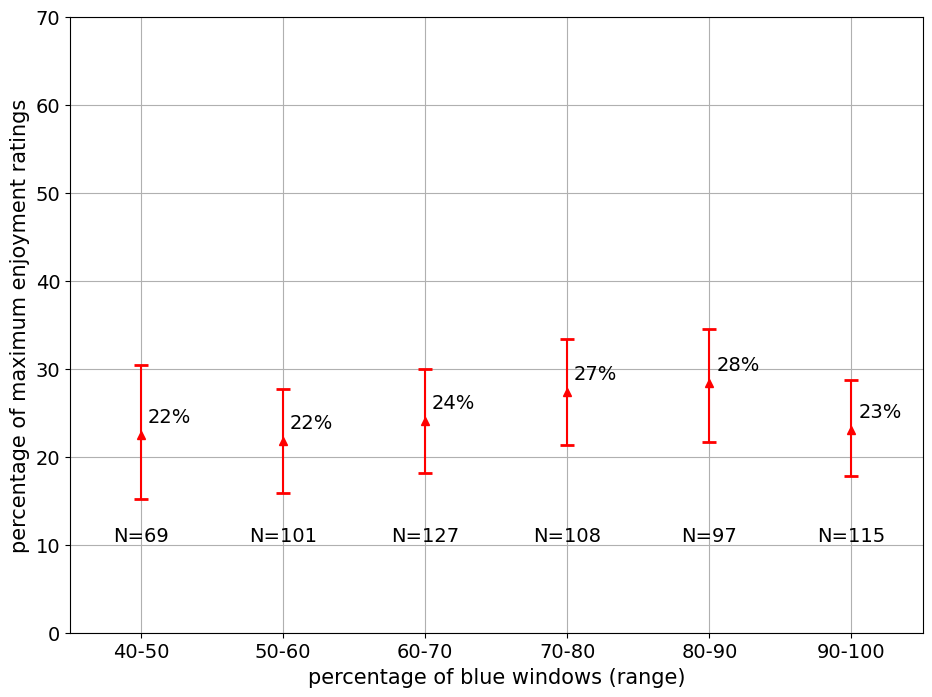

In [47]:
red_below_5 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_red'] < 5]

def get_bin_blue(percent_blue):
    if 30 <= percent_blue < 40:
        return "30_40"
    elif 40 <= percent_blue < 50:
        return "40_50"
    elif 50 <= percent_blue < 60:
        return "50_60"
    elif 60 <= percent_blue < 70:
        return "60_70"
    elif 70 <= percent_blue < 80:
        return "70_80"
    elif 80 <= percent_blue < 90:
        return "80_90"
    elif 90 <= percent_blue <= 100:
        return "90_100"
    else:
        return None

def get_avg_convo_percent_red(corpus, convo_id_lst):
    percent_reds = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_reds.append(convo.meta['percent_red'])
    if len(percent_reds) == 0:
        return "no convo"
    return round(sum(percent_reds) / len(percent_reds), 2)

fix_blue_level_groups = {"40_50" : [], "50_60" : [], "60_70" : [], "70_80" : [], "80_90" : [], "90_100" :[]}

for convo_id in red_below_5:
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_blue(convo.meta['percent_blue'])
    if bin_id in fix_blue_level_groups.keys():
        fix_blue_level_groups[bin_id].append(convo.id)

def make_plot():
    cur_datadict = fix_blue_level_groups

    x = list(cur_datadict.keys())
    y = [round(get_convo_lst_enjoy_per(corpus, cur_datadict[x[i]]),4)*100 for i in range(len(x))]
    y_err = [bootstrap_95_percentage(cur_datadict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    num_of_convo = [len(cur_datadict[a]) for a in x]

    x_names = ["40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
    x = [x_names[i] for i in range(len(x))]
    y = [round(y[i],2) for i in range(len(x))]

    plt.figure(figsize=(11, 8))
    plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2, color='red')
    plt.xlabel('percentage of blue windows (range)', fontsize=15)
    plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    for i, value in enumerate(y):
        plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

    plt.ylim(0, 70)
    plt.xlim(-0.5, len(x_names) - 0.5)
    plt.grid(True)
    plt.show()

make_plot()


### Moving along blue-red axis

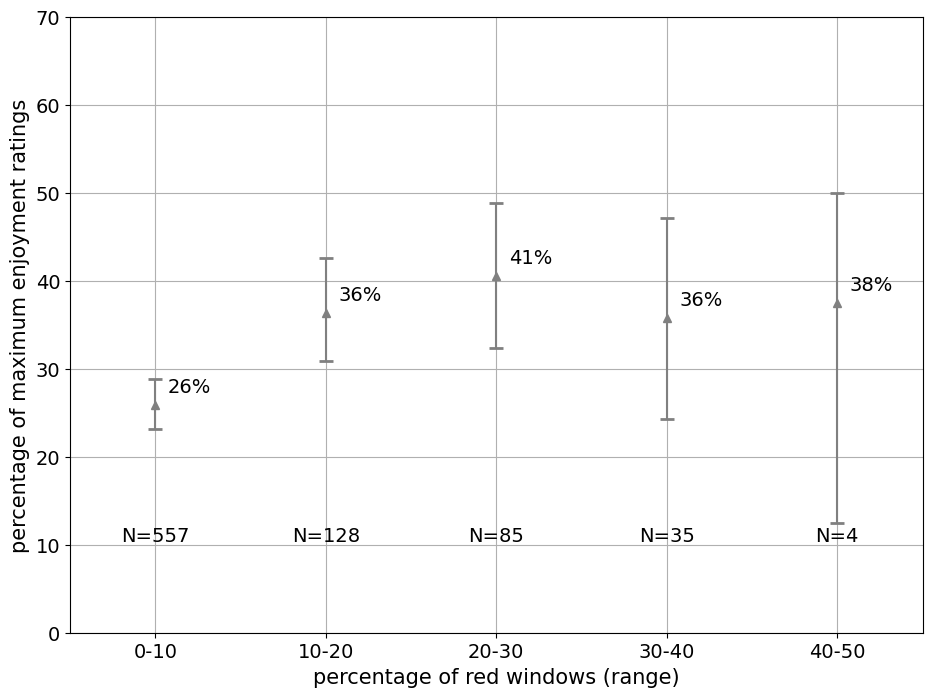

In [48]:
gray_below_40 = [convo.id for convo in corpus.iter_conversations() if convo.meta['percent_gray'] < 40]

fix_red_level_groups = {"0_10" : [], "10_20" : [], "20_30" : [], "30_40" : [], "40_50" : []}

for convo_id in gray_below_40:
    convo = corpus.get_conversation(convo_id)
    bin_id = get_bin_red(convo.meta['percent_red'])
    if bin_id in fix_red_level_groups.keys():
        fix_red_level_groups[bin_id].append(convo.id)

def get_avg_convo_percent_gray(corpus, convo_id_lst):
    percent_grays = []
    for convo_id in convo_id_lst:
        convo = corpus.get_conversation(convo_id)
        percent_grays.append(convo.meta['percent_gray'])
    if len(percent_grays) == 0:
        return "no convo"
    return round(sum(percent_grays) / len(percent_grays), 2)

def make_plot():
    cur_datadict = fix_red_level_groups

    x = list(cur_datadict.keys())
    y = [round(get_convo_lst_enjoy_per(corpus, cur_datadict[x[i]]),4)*100 for i in range(len(x))]
    y_err = [bootstrap_95_percentage(cur_datadict[key]) for key in x]

    lower_errors = [y[i] - err[0] for i, err in enumerate(y_err)]
    upper_errors = [err[1] - y[i] for i, err in enumerate(y_err)]
    asymmetric_error = [lower_errors, upper_errors]

    num_of_convo = [len(cur_datadict[a]) for a in x]

    x_names = ["0-10", "10-20", "20-30", "30-40", "40-50"]
    x = [x_names[i] for i in range(len(x))]
    y = [round(y[i],2) for i in range(len(x))]

    plt.figure(figsize=(11, 8))
    plt.errorbar(x_names, y, yerr=asymmetric_error, fmt='^', capsize=5, capthick=2, color='gray')
    plt.xlabel('percentage of red windows (range)', fontsize=15)
    plt.ylabel(f'percentage of maximum enjoyment ratings', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    for i, value in enumerate(y):
        plt.text(i+0.2, value + 1, f"{str(int(round(value)))}%", ha='center', va='bottom')

    for i, value in enumerate(y):
        plt.text(i, 10, f"N={str(num_of_convo[i])}", ha='center', va='bottom')

    plt.ylim(0, 70)
    plt.xlim(-0.5, len(x_names) - 0.5)
    plt.grid(True)
    plt.show()

make_plot()

### Flips (Changes in dominant speakers)

In [ ]:
# Annotate Number of Flips in each convo

def count_flips_sequence_ratio(sequence_lst):
    count_flips = 0
    total_pairs = 0

    for i in range(len(sequence_lst) - 1):
        if (sequence_lst[i], sequence_lst[i + 1]) in [(1, -1), (-1, 1)]:
            count_flips += 1
        total_pairs += 1

    ratio = count_flips / total_pairs if total_pairs > 0 else 0
    return ratio, count_flips

def remove_short_zero_sequences(input_list, threshold=1000):
    result = []
    i = 0
    while i < len(input_list):
        if input_list[i] == 0:
            start = i
            while i < len(input_list) and input_list[i] == 0:
                i += 1
            if i - start > threshold:
                result.extend([0] * (i - start))
        else:
            result.append(input_list[i])
            i += 1
    return result

def sequence_elements_and_counts(input_list):
    if not input_list:
        return [], []

    elements = [input_list[0]]
    counts = [1]

    for value in input_list[1:]:
        if value == elements[-1]:
            counts[-1] += 1
        else:
            elements.append(value)
            counts.append(1)

    return elements, counts

def remove_short_sequence(sequence_lst, count_lst, threshold=2):
    result_lst = []
    for i in range(len(sequence_lst)):
        count = count_lst[i]
        if count > threshold:
            if len(result_lst) > 0:
                if sequence_lst[i] != result_lst[-1]:
                    result_lst.append(sequence_lst[i])
            else:
                result_lst.append(sequence_lst[i])
    return result_lst

def annotate_convo_flips(corpus):
    for convo in corpus.iter_conversations():
        floor_lst = convo.meta['balance_lst']
        floor_lst = remove_short_zero_sequences(floor_lst)
        floor_sequence, floor_count = sequence_elements_and_counts(floor_lst)
        flip_ratio, flip_count = count_flips_sequence_ratio(floor_sequence)
        convo.meta['flip_count'] = flip_count

In [51]:
annotate_convo_flips(corpus)

In [52]:
flip_lst = [convo.meta['flip_count'] for convo in corpus.iter_conversations()]

### Flip Enjoyment Analysis - Paired test

We match each single-flip conversation with one that has 3 or more flips, such that they have the same proportion of blue, red, and gray windows (with a tolerance of 2%). Then, we compare the enjoyment score between the pairs.

In [84]:
def find_closest_pairs(list1, list2, x=0.01):
    list1final = []
    list2final = []
    for dict1 in list1:
      idx1, score1 = next(iter(dict1.items()))
      closest_dict = None
      min_diff = float('inf')
      for dict2 in list2:
          idx2, score2 = next(iter(dict2.items()))
          diff = abs(score1 - score2)
          if diff < min_diff:
              min_diff = diff
              closest_dict = dict2
      if min_diff > x: continue
      idxf, scoref = next(iter(closest_dict.items()))
      list1final.append(idx1)
      list2final.append(idxf)
      list2.remove(closest_dict)

    return list1final, list2final

In [85]:
# random.seed(42)
# num_pairs_found = []
# b_u_stats = []
# b_p_values = []
# en_u_stats = []
# en_p_values = []
# en_score_1 = []
# en_score_3 = []
# percent_1 = []
# percent_3 = []

# # for i in range(1000):
# flip_1 = [{convo.id : convo.meta['balance_score']} for convo in corpus.iter_conversations() if convo.meta['flip_count'] == 1]
# flip_3 = [{convo.id : convo.meta['balance_score']} for convo in corpus.iter_conversations() if convo.meta['flip_count'] >= 3]
# flip_1 = random.sample(flip_1, len(flip_1))
# flip_3 = random.sample(flip_3, len(flip_3))
# # print(f"Overall: {len(flip_1)} with 1 flip, {len(flip_3)} with 3+ flips")

# control_flip_1, control_flip_3 = find_closest_pairs(flip_1, flip_3)
# num_pairs_found.append(len(control_flip_1))


# control_flip_1_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_1]
# control_flip_3_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_3]
# u_statistic, p_value = mannwhitneyu(control_flip_1_balance, control_flip_3_balance, alternative='two-sided')
# b_u_stats.append(u_statistic)
# b_p_values.append(p_value)


# control_flip_1_enjoy = []
# for idx in control_flip_1:
#   convo = corpus.get_conversation(idx)
#   control_flip_1_enjoy += list(convo.meta['how_enjoyable'].values())
# control_flip_3_enjoy = []
# for idx in control_flip_3:
#   convo = corpus.get_conversation(idx)
#   control_flip_3_enjoy += list(convo.meta['how_enjoyable'].values())
# u_statistic, p_value = mannwhitneyu(control_flip_1_enjoy, control_flip_3_enjoy, alternative='two-sided')
# en_u_stats.append(u_statistic)
# en_p_values.append(p_value)
# en_score_1.append(np.mean(control_flip_1_enjoy))
# en_score_3.append(np.mean(control_flip_3_enjoy))

# count_1 = 0
# count_3 = 0
# for i in range(len(control_flip_1)):
#   convo1 = corpus.get_conversation(control_flip_1[i])
#   convo3 = corpus.get_conversation(control_flip_3[i])
#   if sum(list(convo1.meta['how_enjoyable'].values())) > sum(list(convo3.meta['how_enjoyable'].values())):
#     count_1 += 1
#   elif sum(list(convo1.meta['how_enjoyable'].values())) < sum(list(convo3.meta['how_enjoyable'].values())):
#     count_3 += 1

# percent_1.append(count_1 / len(control_flip_1))
# percent_3.append(count_3 / len(control_flip_3))


# print(f"We found {np.mean(num_pairs_found)} pairs with toleration 0.01\n")
# print("Balance score between two groups (mannwhitneyu):")
# print("\tU Statistic:", np.mean(b_u_stats))
# print("\tP Value:", np.mean(b_p_values))
# print("\nEnjoyable score between two groups (mannwhitneyu):")
# print("\tU Statistic:", np.mean(en_u_stats))
# print("\tP Value:", np.mean(en_p_values))
# print(f"\nEnjoy: with 1 flip {np.mean(en_score_1)}")
# print(f"Enjoy: with 3+ flip {np.mean(en_score_3)}")
# print(f"\nwith 1 flip higher enjoy: {round(np.mean(percent_1), 4)}, with 3+ flip {round(np.mean(percent_3), 4)}")

In [ ]:
tolerance = 2
def pair_elements_blue_red(list1, list2, tolerance=tolerance):
    pairs = []
    used_ids_in_list2 = set()
    for elem1 in list1:
        id1, (value1_1, value2_1) = next(iter(elem1.items()))
        best_match = None
        best_distance = float('inf')
        for elem2 in list2:
            id2, (value1_2, value2_2) = next(iter(elem2.items()))
            if id2 in used_ids_in_list2:
                continue
            distance1 = abs(value1_1 - value1_2)
            distance2 = abs(value2_1 - value2_2)
            if distance1 <= tolerance and distance2 <= tolerance:
                total_distance = distance1 + distance2
                if total_distance < best_distance:
                    best_distance = total_distance
                    best_match = id2
        if best_match is not None:
            pairs.append((id1, best_match))
            used_ids_in_list2.add(best_match)

    return [x[0] for x in pairs], [x[1] for x in pairs]

In [87]:
random.seed(42)
num_pairs_found = []
b_u_stats = []
b_p_values = []
en_u_stats = []
en_p_values = []
en_score_1 = []
en_score_3 = []
percent_1 = []
percent_3 = []

# for i in range(500):
flip_1 = [{convo.id : [convo.meta['percent_blue'], convo.meta['percent_red']]} for convo in corpus.iter_conversations() if convo.meta['flip_count'] == 1]
flip_3 = [{convo.id : [convo.meta['percent_blue'], convo.meta['percent_red']]} for convo in corpus.iter_conversations() if convo.meta['flip_count'] >= 3]
flip_1 = random.sample(flip_1, len(flip_1))
flip_3 = random.sample(flip_3, len(flip_3))
# print(f"Overall: {len(flip_1)} with 1 flip, {len(flip_3)} with 3+ flips")

control_flip_1, control_flip_3 = pair_elements_blue_red(flip_1, flip_3)
num_pairs_found.append(len(control_flip_1))


control_flip_1_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_1]
control_flip_3_balance = [corpus.get_conversation(idx).meta['balance_score'] for idx in control_flip_3]
u_statistic, p_value = mannwhitneyu(control_flip_1_balance, control_flip_3_balance, alternative='two-sided')
b_u_stats.append(u_statistic)
b_p_values.append(p_value)


control_flip_1_enjoy = []
for idx in control_flip_1:
  convo = corpus.get_conversation(idx)
  control_flip_1_enjoy += list(convo.meta['how_enjoyable'].values())
control_flip_3_enjoy = []
for idx in control_flip_3:
  convo = corpus.get_conversation(idx)
  control_flip_3_enjoy += list(convo.meta['how_enjoyable'].values())
u_statistic, p_value = mannwhitneyu(control_flip_1_enjoy, control_flip_3_enjoy, alternative='two-sided')
en_u_stats.append(u_statistic)
en_p_values.append(p_value)
en_score_1.append(np.mean(control_flip_1_enjoy))
en_score_3.append(np.mean(control_flip_3_enjoy))

count_1 = 0
count_3 = 0
for i in range(len(control_flip_1)):
  convo1 = corpus.get_conversation(control_flip_1[i])
  convo3 = corpus.get_conversation(control_flip_3[i])
  if sum(list(convo1.meta['how_enjoyable'].values())) > sum(list(convo3.meta['how_enjoyable'].values())):
    count_1 += 1
  elif sum(list(convo1.meta['how_enjoyable'].values())) < sum(list(convo3.meta['how_enjoyable'].values())):
    count_3 += 1

percent_1.append(count_1 / len(control_flip_1))
percent_3.append(count_3 / len(control_flip_3))


print(f"We found {np.mean(num_pairs_found)} pairs with toleration {tolerance}\n")
print("Balance score between two groups (mannwhitneyu):")
print("\tU Statistic:", np.mean(b_u_stats))
print("\tP Value:", np.mean(b_p_values))
print("\nEnjoyable score between two groups (mannwhitneyu):")
print("\tU Statistic:", np.mean(en_u_stats))
print("\tP Value:", np.mean(en_p_values))
print(f"\nEnjoy: with 1 flip {np.mean(en_score_1)}")
print(f"Enjoy: with 3+ flip {np.mean(en_score_3)}")
print(f"\nwith 1 flip higher enjoy: {round(np.mean(percent_1), 4)}%, with 3+ flip {round(np.mean(percent_3), 4)}%")

We found 90.0 pairs with toleration 2

Balance score between two groups (mannwhitneyu):
	U Statistic: 3866.0
	P Value: 0.5995952992175173

Enjoyable score between two groups (mannwhitneyu):
	U Statistic: 14893.0
	P Value: 0.1739577730491806

Enjoy: with 1 flip 7.166666666666667
Enjoy: with 3+ flip 7.377777777777778

with 1 flip higher enjoy: 0.3778%, with 3+ flip 0.5333%


### Capture Mixed Stereotype Conversations

In [ ]:
def get_first_second_half_convo(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    balance_lst = convo.meta['balance_lst']
    return balance_lst[:int(len(balance_lst)*0.6)], balance_lst[int(len(balance_lst)*0.4):]

def get_type_dominating_throughout(balance_lst, dominating_throughout_threshold=75):
    if balance_lst == []: return "invalid"
    count_ones = balance_lst.count(1)
    percent_ones = (count_ones / len(balance_lst)) * 100
    count_neg_ones = balance_lst.count(-1)
    percent_neg_ones = (count_neg_ones / len(balance_lst)) * 100
    return percent_ones >= dominating_throughout_threshold or percent_neg_ones >= dominating_throughout_threshold

def get_type_back_and_forth(balance_lst, back_and_forth_threshold=60):
    if balance_lst == []: return "invalid"
    count_zeros = balance_lst.count(0)
    percent_zeros = (count_zeros / len(balance_lst)) * 100
    return percent_zeros >= back_and_forth_threshold

def get_type_interleaved(balance_lst, red_threshold=25):
    if balance_lst == []: return "invalid"
    count_neg1 = balance_lst.count(-1)
    total_elements = len(balance_lst)
    percent_neg1 = (count_neg1 / total_elements) * 100
    return percent_neg1 > red_threshold

def get_lst_balance_type(lst):
    if get_type_interleaved(lst):
        return "interleaved"
    elif get_type_dominating_throughout(lst):
        return "dominating_throughout"
    elif get_type_back_and_forth(lst):
        return "back_and_forth"
    else:
        return None
    
def get_mixed_stereotype_conversation(corpus, convo_id):
    first, second = get_first_second_half_convo(corpus, convo_id)
    first_type = get_lst_balance_type(first)
    second_type = get_lst_balance_type(second)
    if first_type is None or second_type is None:
        return None
    if first_type != second_type:
        return [first_type, second_type]
    else:
        return [first_type]

In [59]:
mixed_convos = {}
count = 0
for convo in corpus.iter_conversations():
    convo_type = get_mixed_stereotype_conversation(corpus, convo.id)
    if convo_type is not None and len(convo_type) == 2:
        mixed_convos.update({convo.id : convo_type})
        count += 1
        convo.meta["mixed"] = True
    else:
        convo.meta['mixed'] = False
count

47

In [ ]:
def count_unique_values(input_dict):
    value_counts = Counter(tuple(v) for v in input_dict.values())
    return dict(value_counts)

mixed_convos_plot_dict = {}
for k, v in mixed_convos.items():
    key = v[0]+v[1]
    if key not in mixed_convos_plot_dict.keys():
        mixed_convos_plot_dict.update({key : []})
    mixed_convos_plot_dict[key].append(k)
# for k, v in mixed_convos_plot_dict.items():
#     print(k, len(v))

count_unique_values(mixed_convos)

{('back_and_forth', 'dominating_throughout'): 11,
 ('back_and_forth', 'interleaved'): 13,
 ('interleaved', 'dominating_throughout'): 6,
 ('interleaved', 'back_and_forth'): 13,
 ('dominating_throughout', 'interleaved'): 4}

In [62]:
labels = ["back_and_forthdominating_throughout", "back_and_forthinterleaved", "interleaveddominating_throughout", "interleavedback_and_forth", "dominating_throughoutinterleaved"]
names = ["bf-dt", "bf-ad", "ad-dt", "ad-bf", "dt-ad"]
# for i, label in enumerate(labels):
#     plot_multi_conversation_floors(corpus, mixed_convos_plot_dict[label])

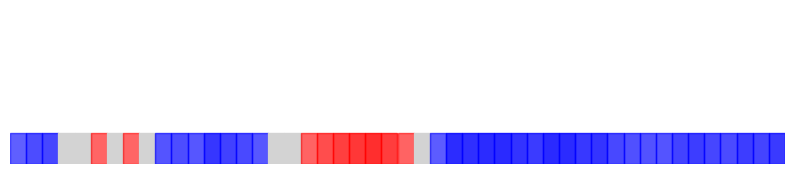

red : 18.75, blue : 66.67, gray : 14.58


In [99]:
plot_individual_conversation_floors(corpus, mixed_convos_plot_dict["interleaveddominating_throughout"][0])

## Exploratory Analysis

### Role Consistency of Speakers

In [63]:
len([speaker.id for speaker in corpus.iter_speakers() if len(speaker.get_conversation_ids()) > 1])

733

In [64]:
min_num_of_convo = 2

speaker_convo_count = {}
for convo in corpus.iter_conversations():
  if convo.meta['balance_type'] != 'low_balance': continue
  sp_lst = convo.get_speaker_ids()
  for sp_id in sp_lst:
      if sp_id not in speaker_convo_count.keys():
          speaker_convo_count.update({sp_id : 0})
      speaker_convo_count[sp_id] += 1
      
sp_with_more_than_one_convo = []
for sp, count in speaker_convo_count.items():
    if count >= min_num_of_convo: sp_with_more_than_one_convo.append(sp)

len(sp_with_more_than_one_convo)

148

In [65]:
def compute_percent_agreement(data_dict):
    same_response_count = 0
    total_responses = len(data_dict)

    for user_id, responses in data_dict.items():
        if responses[1] == responses[2]:
            same_response_count += 1

    percent_agreement = (same_response_count / total_responses) * 100
    return percent_agreement

In [66]:
# sp_primary_secondary_labels = {}
# count = 0
# repeated_convo = []
# for sp_id in sp_with_more_than_one_convo:
#     sp_primary_secondary_labels.update({sp_id : []})
#     sp = corpus.get_speaker(sp_id)
#     convo_id_lst = sp.get_conversation_ids()
#     for convo_id in convo_id_lst:
#         convo = corpus.get_conversation(convo_id)
#         if convo.meta['balance_type'] != 'low_balance': continue
#         repeated_convo.append(convo_id)
#         utt_lst = convo.get_utterance_ids()[1:-1]
#         primary_sp = balance_transformer._get_ps(corpus, utt_lst, primary_threshold=0.65) # so now, no way there is balanced convo, all with a ps and ss
#         if primary_sp == None:
#             sp_primary_secondary_labels[sp_id].append('balanced')
#             print("bad: should not get here")
#         if primary_sp == sp_id:
#             sp_primary_secondary_labels[sp_id].append('primary')
#         else:
#             sp_primary_secondary_labels[sp_id].append('secondary')
#     assert(len(sp_primary_secondary_labels[sp_id]) >= 2)

# percent_agreement = []
# cohen_kappa = []
# for x in range(1000):
#     sp_random_pairs = {}
#     for sp_id in sp_with_more_than_one_convo:
#         label_lst = sp_primary_secondary_labels[sp_id]
#         sampled_label = random.sample(label_lst, 2)
#         sp_random_pairs.update({sp_id : {1 : sampled_label[0], 2 : sampled_label[1]}})
#     percent_agreement.append(compute_percent_agreement(sp_random_pairs))

#     first_answers = []
#     second_answers = []

#     for user_id, answers in sp_random_pairs.items():
#         first_answers.append(answers[1])
#         second_answers.append(answers[2])

#     kappa = cohen_kappa_score(first_answers, second_answers)
#     cohen_kappa.append(kappa)

# print(f"Percent Agreement: {np.mean(percent_agreement)}%")
# print("Cohen's Kappa Score:", np.mean(cohen_kappa))

In [ ]:
def plot_color_corpus_RGB_distribution(corpus, color="red"):
    data = [convo.meta[f'percent_{color}'] for convo in corpus.iter_conversations()]

    mean = round(np.mean(data), 2)
    median = round(np.median(data), 2)
    percentile_25 = round(np.percentile(data, 25), 2)
    percentile_75 = round(np.percentile(data, 75), 2)

    plt.hist(data, bins=range(0, 100), edgecolor='black', alpha=0.7)

    plt.title(f'Distribution of Percentage of {color} in each Conversation')
    plt.xlabel(f'Percentage of {color} (%)')
    plt.ylabel('Number of Conversations')

    plt.axvline(mean, color='r', linestyle='dotted', linewidth=1, label=f'Mean {mean}')
    plt.axvline(median, color='g', linestyle='dotted', linewidth=1, label=f'Median {median}')
    plt.axvline(percentile_25, color='b', linestyle='dotted', linewidth=1, label=f'25th Percentile {percentile_25}')
    plt.axvline(percentile_75, color='b', linestyle='dotted', linewidth=1, label=f'75th Percentile {percentile_75}')

    plt.legend()
    plt.show()

plot_color_corpus_RGB_distribution(corpus, color="blue")

In [ ]:
def plot_balance_type_speaker_difference_with_statistical_test(corpus, balance_type="low_balance", show_plot_and_stats=True):
    ps_group = []
    ss_group = []

    for convo in corpus.iter_conversations():
        if convo.meta['primary_speaker'] == None: continue
        if convo.meta['balance_type'] == balance_type:
            ps_group.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['primary_speaker']]])
            ss_group.append(convo.meta['how_enjoyable'][convo.meta['speaker_group'][convo.meta['secondary_speaker']]])

    if show_plot_and_stats:
        u_statistic, p_value = wilcoxon(ps_group, ss_group, alternative='greater')
        print("U Statistic:", u_statistic)
        print("P Value:", p_value)


    if show_plot_and_stats:
        max_score = int(max(max(ps_group), max(ss_group))) + 1
        min_score = int(min(min(ps_group), min(ss_group)))

        # Create bins for each enjoyment score
        bins = np.arange(min_score, max_score + 1) - 0.5

        # Histograms for high and low balance scores
        primary_hist, _ = np.histogram(ps_group, bins=bins)
        secondary_hist, _ = np.histogram(ss_group, bins=bins)

        # Define the position of the bars
        bar_width = 0.25
        index = np.arange(min_score, max_score)

        fig, ax = plt.subplots()
        bar1 = ax.bar(index - bar_width/2, primary_hist, bar_width, label=f'Primary (N={len(ps_group)})', color='blue')
        bar2 = ax.bar(index + bar_width/2, secondary_hist, bar_width, label=f'Secondary (N={len(ss_group)})', color='red')

        ax.set_xlabel('Enjoyment (scale 1-9)')
        ax.set_ylabel('Number of Speakers')
        ax.set_title(f'Primary vs Secondary Speaker Enjoyment Scores Distribution for {balance_type} Conversations')
        ax.set_xticks(index)
        ax.set_xticklabels([str(x) for x in range(min_score, max_score)])
        ax.legend()
        plt.show()

plot_balance_type_speaker_difference_with_statistical_test(corpus, balance_type="low_balance", show_plot_and_stats=False)